In [45]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

BUTTERFLIES_BBOXES_FILEPATH = Path('./butterflies_bboxes.csv')

IMAGE_FOLDER = Path('./butterfly_medium_images')

df = pd.read_csv(BUTTERFLIES_BBOXES_FILEPATH)
df = df[df['exclude'] == 0]
df = df.reset_index(drop=True)

n_gpus = num_distrib() or 1
workers = min(8, num_cpus()//n_gpus)

size = 256

bs = 32

lr = 1e-5 # Param("Learning rate", float)=1e-3,
alpha = 0.9 # Param("Alpha", float)=0.9,
mom = 0.9 # Param("Momentum", float)=0.9,
eps = 1e-7 # Param("epsilon", float)=1e-7,
epochs = 25 # Param("Number of epochs", int)=5,
gpu = None #:Param("GPU to run on", str)=None,

gpu = setup_distrib(gpu)

np.random.seed(13)

In [46]:
train_class_count = int(0.8*df['class'].value_counts().values.min()) # Take first 80% of each class as training data

valid_idxs = []
for c in df['class'].unique():
    valid_idxs.extend(df[df['class'] == c].index.values[train_class_count:])
print(len(valid_idxs), len(df))

In [57]:
data = (ImageList.from_df(df, path=IMAGE_FOLDER, folder='', cols='filename').split_by_idx(valid_idxs)
        .label_from_df('class').transform(get_transforms(), size=size)
        .databunch(bs=bs, num_workers=workers)
        .presize(size, scale=(0.75,1))
        .normalize(imagenet_stats))

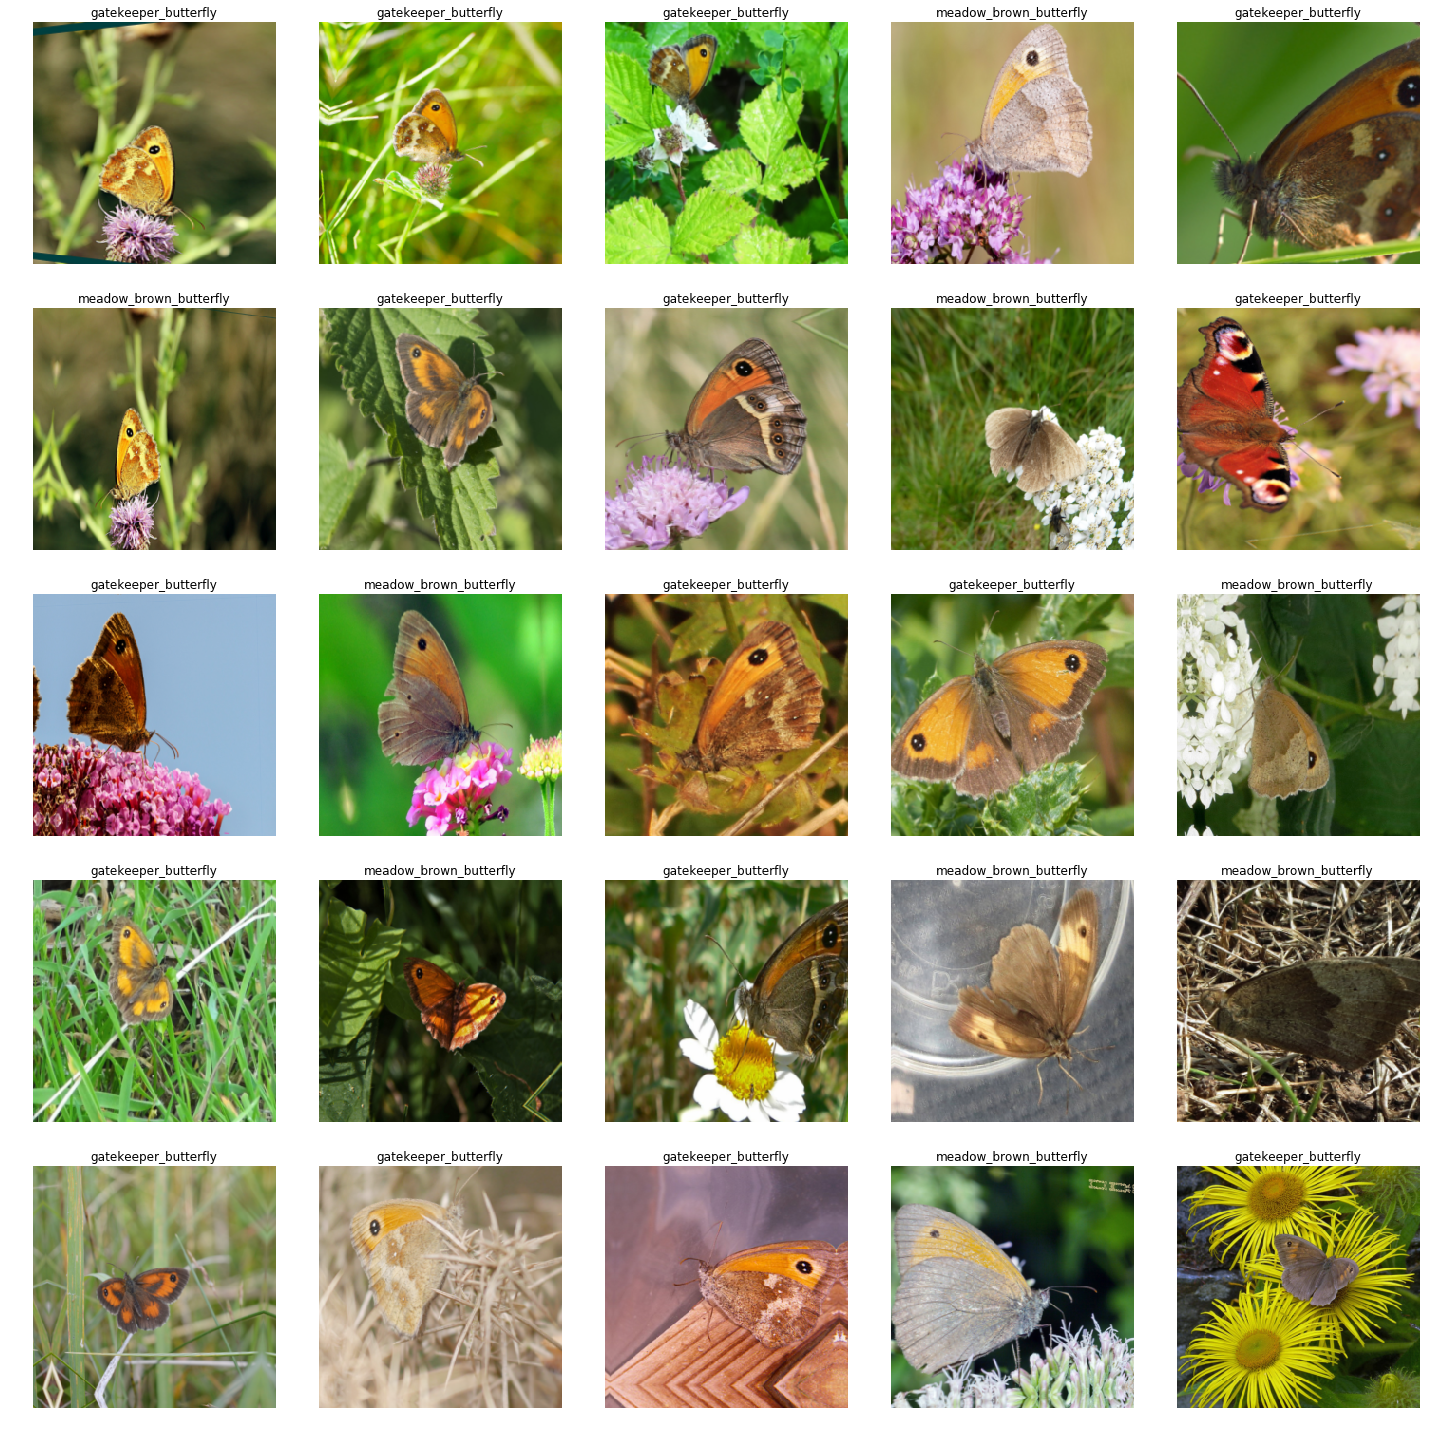

In [58]:
data.show_batch(ds_type=DatasetType.Train)

In [3]:
if gpu is None: bs *= torch.cuda.device_count()
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

print(f'lr: {lr}; size: {size}; alpha: {alpha}; mom: {mom}; eps: {eps}')

    
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

if gpu is None:       learn.to_parallel()
elif num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
    
learn.fit_one_cycle(10, lr)

lr: 0.001; size: 256; alpha: 0.9; mom: 0.9; eps: 1e-07


In [4]:
learn.save('butterflies-full-1')

In [5]:
learn.load('butterflies-full-1');

In [6]:
learn.unfreeze()

In [7]:
learn.fit_one_cycle(10, lr,
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='butterfly-best-unfreeze')])

Better model found at epoch 0 with accuracy value: 0.6111111044883728.
Better model found at epoch 1 with accuracy value: 0.7685185074806213.
Better model found at epoch 2 with accuracy value: 0.7870370149612427.
Better model found at epoch 3 with accuracy value: 0.7962962985038757.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


In [8]:
learn.save('butterflies-full-2')

In [9]:
learn.load('butterflies-full-2');

Learner(data=ImageDataBunch;

Train: LabelList (433 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly
Path: butterfly_medium_images_full;

Valid: LabelList (108 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,gatekeeper_butterfly,gatekeeper_butterfly,gatekeeper_butterfly
Path: butterfly_medium_images_full;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


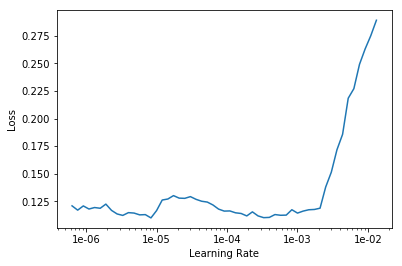

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(3, max_lr=slice(2e-6,2e-4), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='butterfly-best')])

Better model found at epoch 0 with accuracy value: 0.8240740895271301.


In [12]:
learn.save('butterflies-full-3')

In [13]:
learn.load('butterflies-full-3')

Learner(data=ImageDataBunch;

Train: LabelList (433 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly
Path: butterfly_medium_images_full;

Valid: LabelList (108 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,gatekeeper_butterfly,gatekeeper_butterfly,gatekeeper_butterfly
Path: butterfly_medium_images_full;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
    

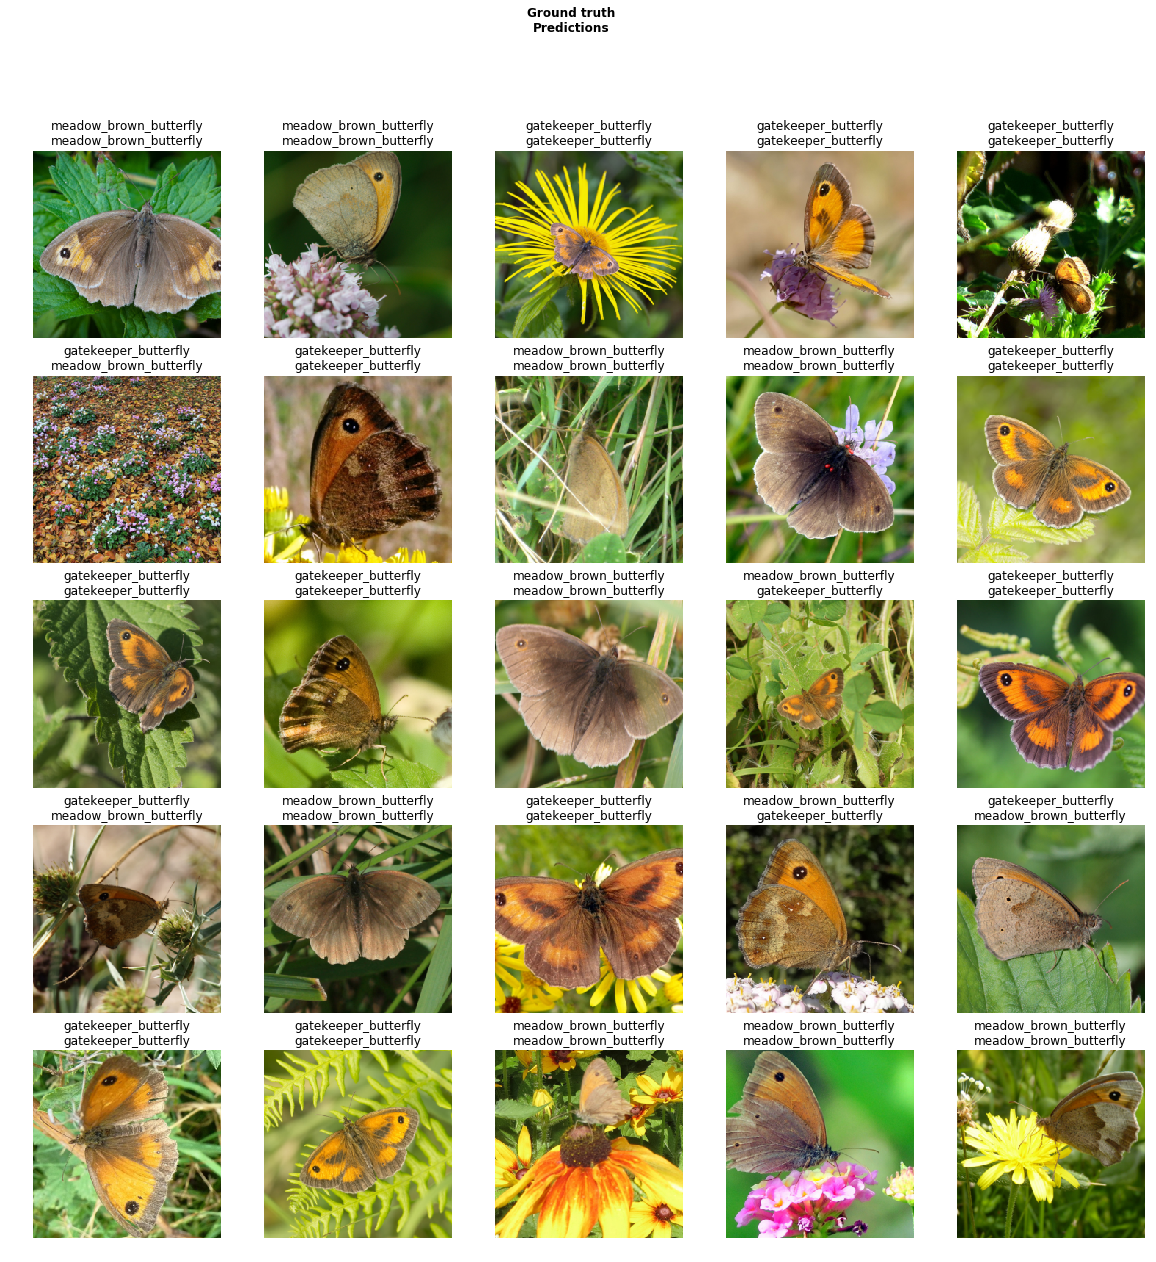

In [14]:
learn.show_results()